In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 13.0.1


# FMCW Radar Link Budget

## Introduction

Frequency Modulated Continuous Wave (FMCW) radar is a type of radar system that utilizes continuous transmission of a signal that varies in frequency over time. The link budget of an FMCW radar system is a crucial aspect that determines the overall performance and range of the radar. It involves analyzing the power budget of the system to ensure that the transmitted signal can reach the target and the received signal can be properly detected and processed. Factors such as transmit power, antenna gain, propagation losses, and receiver sensitivity play a key role in determining the link budget of an FMCW radar system. Understanding and optimizing the link budget is essential for designing an effective and efficient FMCW radar system for various applications such as automotive radar, surveillance, and navigation.

This illustration showcases a simulation of an FMCW radar using the [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) framework. It additionally provides a demonstration of fundamental range and Doppler processing techniques for extracting target range and velocity information.

## Radar Link Budget Analysis

Radar link budget analysis is a critical process for determining the power levels throughout the radar system’s signal chain, from transmission, through propagation, to reception. The goal is to ensure that the radar can detect and track targets at the desired range. The analysis involves understanding how transmitted power is affected by various factors, such as antenna gains, propagation losses, and target characteristics, ultimately determining if the received signal is strong enough for detection.

The key equation used in radar link budget analysis is derived from the **Radar Range Equation**:

$$
P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4\pi)^3 R^4 L_s}
$$

Where:

- $( P_t )$ = **Transmitted power** (W)
- $( G_t )$ = **Transmitting antenna gain**
- $( G_r )$ = **Receiving antenna gain**
- $( \lambda )$ = **Wavelength** of the radar signal (m), $( \lambda = \frac{c}{f} )$ where $( c )$ is the speed of light (3×10⁸ m/s) and $( f )$ is the frequency (Hz)
- $( \sigma )$ = **Radar cross-section (RCS)** of the target (m²)
- $( R )$ = **Range** to the target (m)
- $( L_s )$ = **System losses**, including propagation losses, hardware inefficiencies, and atmospheric attenuation

### 1. Transmitted Power $(P_t)$:

The radar system transmits a signal with power $( P_t )$ (in watts). This power is directed through the radar's transmitting antenna, which has a specific gain $( G_t )$, concentrating the energy into a particular direction.

$$
P_{\text{transmit}} = P_t G_t
$$

### 2. Antenna Gain $(G_t)$ and $(G_r)$:

Antenna gain is a measure of how well the antenna focuses the transmitted (or received) energy in a specific direction. It is typically expressed as:

$$
G = \frac{4 \pi A_{\text{antenna}}}{\lambda^2}
$$

Where $( A_{\text{antenna}} )$ is the effective area of the antenna, and $( \lambda )$ is the wavelength.

### 3. Free-Space Path Loss (FSPL):

As the signal propagates through space, it experiences **free-space path loss (FSPL)**, which increases with the square of the distance from the radar and the square of the operating frequency. The FSPL is given by:

$$
L_{\text{fspl}} = \left( \frac{4 \pi R}{\lambda} \right)^2 = \frac{(4 \pi R f)^2}{c^2}
$$

Where:

- $( R )$ is the distance to the target (m)
- $( f )$ is the radar frequency (Hz)
- $( c )$ is the speed of light (3×10⁸ m/s)

### 4. Radar Cross Section (RCS) $( \sigma )$:

The radar cross-section $( \sigma )$ represents how much of the transmitted signal is reflected back by the target. Larger or more reflective targets have a higher RCS, which increases the power of the reflected signal:

$$
P_{\text{return}} = P_{\text{transmit}} \frac{\sigma}{4 \pi R^2}
$$

### 5. Received Power $(P_r)$:

The power received by the radar after the signal is reflected from the target is determined by the radar range equation:

$$
P_r = \frac{P_t G_t G_r \lambda^2 \sigma}{(4 \pi)^3 R^4 L_s}
$$

- $( R^4 )$: The signal experiences two-way propagation, so the range term is raised to the fourth power — $( R^2 )$ for the transmission from radar to the target and another $( R^2 )$ for the return path.
- $( L_s )$: This term represents **total system losses**, which can include:
  - Propagation losses (e.g., due to atmospheric absorption).
  - Antenna losses (e.g., due to inefficiencies in the antenna design).
  - Polarization mismatches and other hardware inefficiencies.

### 6. Noise Power $(P_{\text{noise}})$:

For the radar system to successfully detect a target, the received power \( P*r \) must exceed the **minimum detectable signal (MDS)**, \( P*{\text{min}} \), which is defined by the receiver sensitivity and the noise level in the system:

$$
P_{\text{noise}} = k T B F
$$

Where:

- $( k )$ = **Boltzmann's constant** (1.38×10⁻²³ J/K)
- $( T )$ = **System temperature** (Kelvin)
- $( B )$ = **Receiver bandwidth** (Hz)
- $( F )$ = **Receiver noise figure**

### 7. Signal-to-Noise Ratio $(SNR)$:

The **signal-to-noise ratio $(SNR)$** is a key performance metric that determines whether the target can be detected reliably. A higher SNR means the signal is strong compared to the noise, making detection easier.

$$
SNR = \frac{P_r}{P_{\text{noise}}}
$$

## Simulation Example

### Radar System Parameters

In this simulation, we are building a radar system based on the following parameters:

#### Transmitter

- $P_t = 13$ dBm
- $G_t = 12$ dB
- $N_p = 512$ (number of pulses)

#### Receiver

- $f_s = 20 \times 10^6$ (samping rate)
- $N_s = 1024$ (number of samples per pulse)
- $G_r = 12$ dB
- $\lambda = 3e8/76.5e9$ m
- $F = 11$ dB

#### Target

- $\sigma = 10$ dBsm
- $R = 100$ m

### Build Simulation Model


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

In [3]:
antenna_gain = 12

az_angle = np.arange(-80, 81, 1)
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 4) + antenna_gain

el_angle = np.arange(-80, 81, 1)
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 20) + antenna_gain

_Plot the antenna patterns_


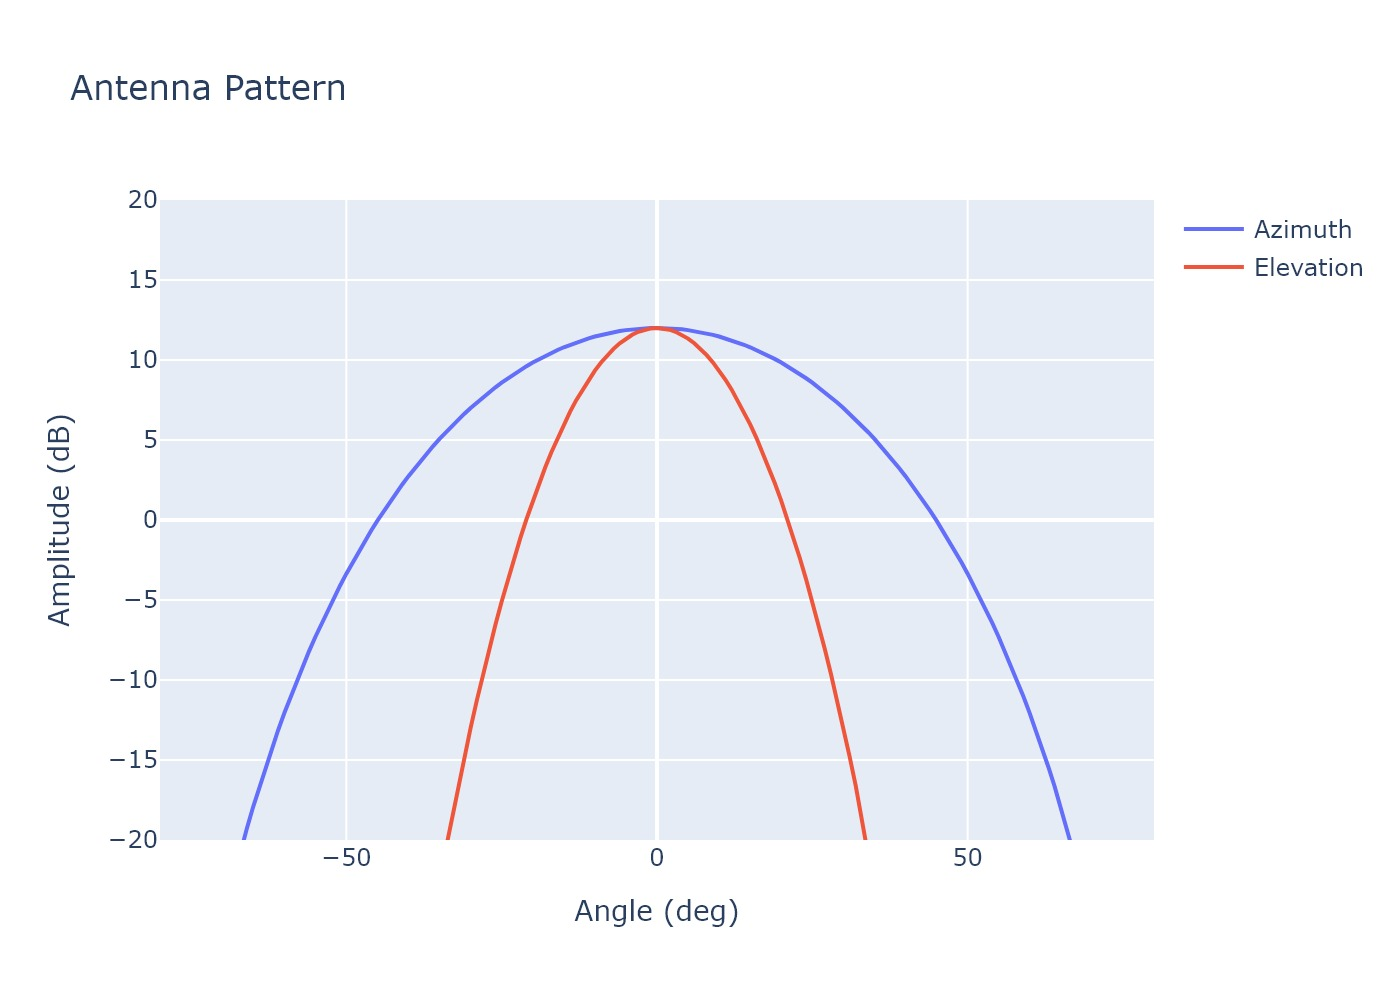

In [4]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=az_angle,
        y=az_pattern,
        name="Azimuth",
    )
)
fig.add_trace(
    go.Scatter(
        x=el_angle,
        y=el_pattern,
        name="Elevation",
    )
)

fig.update_layout(
    title="Antenna Pattern",
    yaxis=dict(title="Amplitude (dB)", range=[-20, 20]),
    xaxis=dict(title="Angle (deg)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

#### Transmitter Channel


In [5]:
tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Radar Transmitter


In [6]:
tx = Transmitter(
    f=[76.3e9, 76.7e9],
    t=5.12e-05,
    tx_power=13,
    prp=5.5e-05,
    pulses=512,
    channels=[tx_channel],
)

#### Receiver Channel


In [7]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Radar Receiver


In [8]:
rx = Receiver(
    fs=20e6,
    noise_figure=11,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    bb_type="real",
    channels=[rx_channel],
)

#### Radar System


In [9]:
radar = Radar(transmitter=tx, receiver=rx)

#### Targets


In [10]:
target_1 = dict(location=(100, 0, 0), speed=(0, 0, 0), rcs=10, phase=0)

targets = [target_1]

#### Simulate Baseband Signals

Utilize the `simulator.sim_radar` module to simulate baseband samples from the defined radar system and its targets.

The output is a dictionary containing the timestamp, noise, and baseband data, each represented as a 3D matrix with the following structure:

`[channels, pulses, ADC samples]`

To provide greater flexibility, the noise and baseband data are kept separate. Users must combine these two datasets to generate the noisy baseband.


In [11]:
from radarsimpy.simulator import sim_radar

data = sim_radar(radar, targets)
timestamp = data["timestamp"]
baseband = data["baseband"]+data["noise"]
noise = data["noise"]

### Radar Signal Processing

#### Range-Doppler processing

Perform the FFT across the range profiles could obtan the Doppler information from the data, which is also known as the Doppler FFT.


In [12]:
import radarsimpy.processing as proc

range_doppler = np.fft.fftshift(
    proc.range_doppler_fft(baseband), axes=1
)

noise_range_doppler = np.fft.fftshift(
    proc.range_doppler_fft(noise), axes=1
)

max_per_range_bin = np.max(np.abs(range_doppler), axis=1)
noise_mean = np.mean(np.abs(noise_range_doppler), axis=1)

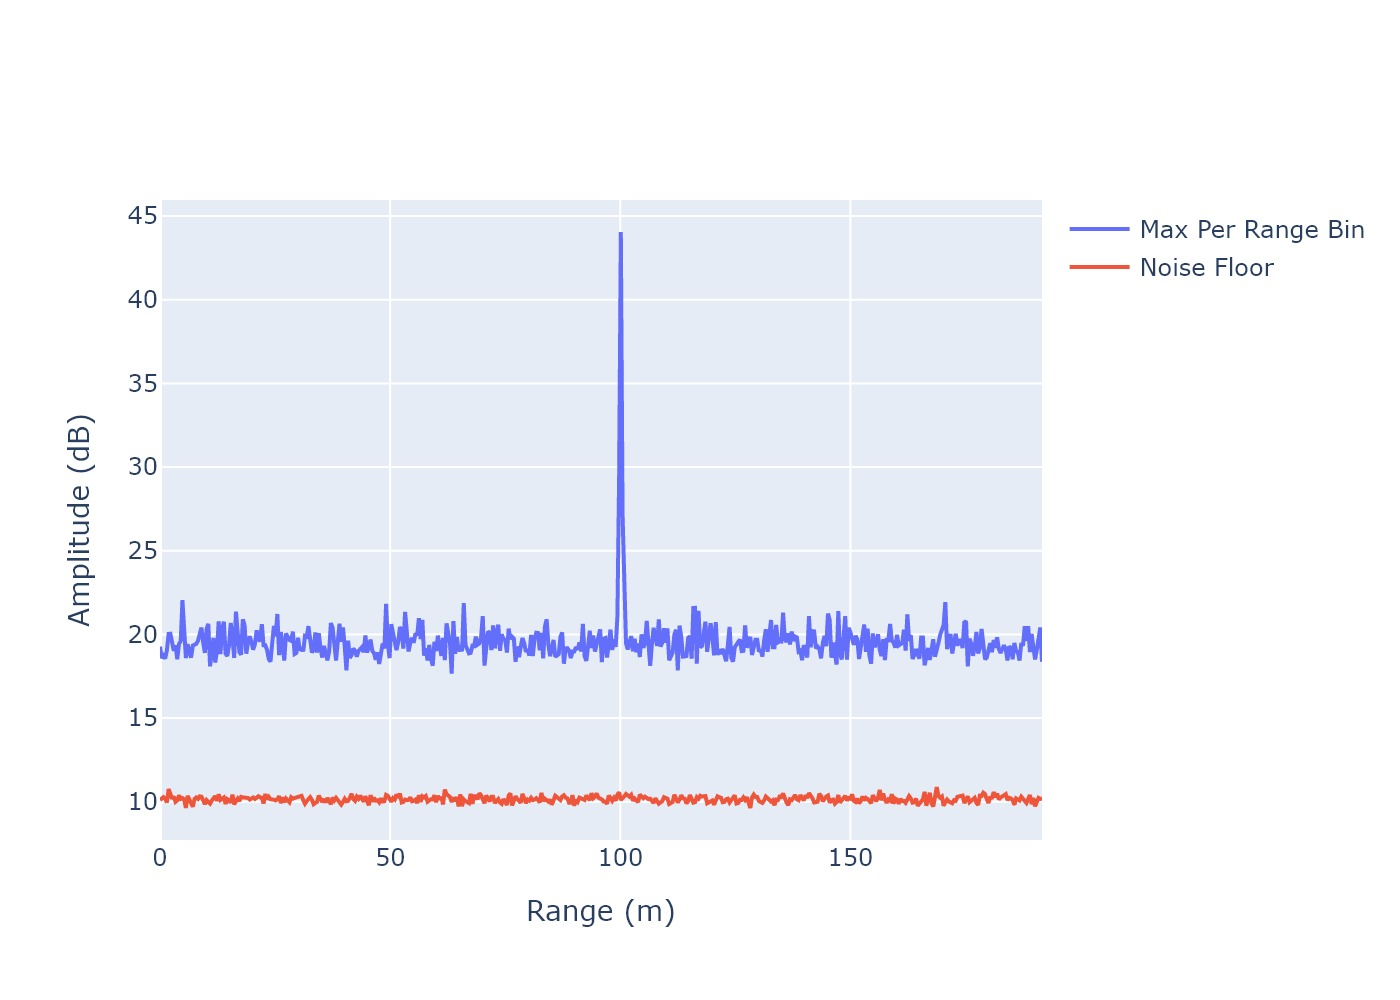

In [13]:
valid_range_bins = int(radar.sample_prop["samples_per_pulse"]/2)

max_range = (
    3e8
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 4
)

range_axis = np.linspace(
    0, max_range, valid_range_bins, endpoint=False
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20*np.log10(max_per_range_bin[0, 0:valid_range_bins]),
        name="Max Per Range Bin"
    )
)

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20*np.log10(noise_mean[0, 0:valid_range_bins]),
        name="Noise Floor"
    )
)

fig.update_layout(
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Compare Simulated SNR with Theory

Based on the equations above, the calculated SNR from the theory is:

$$
SNR = P_r - P_{\text{noise}} \text{ in decibels}
$$

While

$$
P_r = 13(P_t) + 12(G_t) + 12(G_r) + 20 \times \log_{10}{\frac{3 \times 10^8(c)/76.5 \times 10^9(\lambda)}{(4 \pi)^{3/2} \times 100^2(R)}} + 10(\sigma) = -114.10 \text{ dBm}
$$

For the noise power, the receiver bandwidth $B$ can be calculated based on the receiver sampling rate and the total data acquision time:

$$
B = 10 \times \log_{10}{\frac{20 \times 10^6 (f_s)}{1024(N_s) \times 512(N_p)}} = 15.814 \text{ dB}
$$

Then:

$$
P_{\text{noise}} = 11(F)+15.814(B)+10 \times \log_{10}{1.38 \times 10^{-23}(k)}+10 \times \log_{10}{290(T)}+30 =-147.16 \text{ dBm}
$$

Thus, the calculated $SNR$ (in decibels) would be:

$$
SNR = P_r - P_{\text{noise}} = 33.06 \text{ dB}
$$

The calculated SNR matches with the simulated result as shown in the plot above.
